# Loading libraries

In [1]:
import pymysql
import getpass 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

from sqlalchemy import create_engine

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import cohen_kappa_score

········


In [ ]:
password = getpass.getpass()

In [2]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

1) Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features. Use the data from 2005.

In [3]:
query1 = '''SELECT f.film_id, f.rental_duration, f.rental_rate, f.length, f.rating, c.name
FROM film as f
JOIN film_category as fc
ON f.film_id = fc.film_id
JOIN category as c
ON fc.category_id = c.category_id
JOIN inventory as i
ON i.film_id = f.film_id;
'''

In [4]:
df = pd.read_sql_query(query1, engine)

df = df.replace(r'^\s*$', np.nan, regex=True)

df

,film_id,rental_duration,rental_rate,length,rating,name
0,19,6,0.99,113,PG,Action
1,19,6,0.99,113,PG,Action
2,19,6,0.99,113,PG,Action
3,19,6,0.99,113,PG,Action
4,19,6,0.99,113,PG,Action
...,...,...,...,...,...,...
4576,989,4,4.99,74,R,Travel
4577,989,4,4.99,74,R,Travel
4578,989,4,4.99,74,R,Travel
4579,989,4,4.99,74,R,Travel


2) Create a query to get the total amount of rentals in June for each film.

In [5]:
query2 = '''SELECT film_id, title, rental_duration, rental_rate, length, rating, name, COUNT(rental_id) as rentals_june FROM (SELECT f.film_id, f.title, f.rental_duration, f.rental_rate, f.length, f.rating, c.name, r.rental_id, r.rental_date,  
CASE   
	WHEN r.rental_date BETWEEN '2005-05-01' AND '2005-05-31' THEN TRUE  
    ELSE FALSE END AS rents_in_june 
    FROM film as f 
    JOIN inventory as i 
    ON f.film_id = i.film_id 
    JOIN rental as r 
    ON i.inventory_id = r.inventory_id
    JOIN film_category as fc
    ON f.film_id = fc.film_id
    JOIN category as c
    ON fc.category_id = c.category_id) as sub1
WHERE rents_in_june LIKE 1 
GROUP BY film_id, name;
'''

In [6]:
df_rents_june = pd.read_sql_query(query2, engine)

df_rents_june

,film_id,title,rental_duration,rental_rate,length,rating,name,rentals_june
0,19,AMADEUS HOLY,6,0.99,113,PG,Action,1
1,21,AMERICAN CIRCUS,3,4.99,129,R,Action,2
2,56,BAREFOOT MANCHURIAN,6,2.99,129,G,Action,1
3,67,BERETS AGENT,5,2.99,77,PG-13,Action,1
4,97,BRIDE INTRIGUE,7,0.99,56,G,Action,1
...,...,...,...,...,...,...,...,...
622,872,SWEET BROTHERHOOD,3,2.99,185,R,Travel,2
623,878,TEEN APOLLO,3,4.99,74,G,Travel,3
624,914,TROUBLE DATE,6,2.99,61,PG,Travel,1
625,931,VALENTINE VANISHING,7,0.99,48,PG-13,Travel,2


3) Do the same with July.

In [7]:
query3 = '''SELECT film_id, title, rental_duration, rental_rate, length, rating, name, COUNT(rental_id) as rentals_july FROM (SELECT f.film_id, f.title, f.rental_duration, f.rental_rate, f.length, f.rating, c.name, r.rental_id, r.rental_date,  
CASE   
	WHEN r.rental_date BETWEEN '2005-06-01' AND '2005-06-30' THEN TRUE  
    ELSE FALSE END AS rents_in_july 
    FROM film as f 
    JOIN inventory as i 
    ON f.film_id = i.film_id 
    JOIN rental as r 
    ON i.inventory_id = r.inventory_id
    JOIN film_category as fc
    ON f.film_id = fc.film_id
    JOIN category as c
    ON fc.category_id = c.category_id) as sub1
WHERE rents_in_july LIKE 1 
GROUP BY film_id, name;
'''

In [8]:
df_rents_july = pd.read_sql_query(query3, engine)

df_rents_july

,film_id,title,rental_duration,rental_rate,length,rating,name,rentals_july
0,19,AMADEUS HOLY,6,0.99,113,PG,Action,4
1,21,AMERICAN CIRCUS,3,4.99,129,R,Action,3
2,29,ANTITRUST TOMATOES,5,2.99,168,NC-17,Action,2
3,56,BAREFOOT MANCHURIAN,6,2.99,129,G,Action,3
4,67,BERETS AGENT,5,2.99,77,PG-13,Action,2
...,...,...,...,...,...,...,...,...
895,931,VALENTINE VANISHING,7,0.99,48,PG-13,Travel,2
896,977,WINDOW SIDE,3,2.99,85,R,Travel,3
897,981,WOLVES DESIRE,7,0.99,55,NC-17,Travel,4
898,988,WORKER TARZAN,7,2.99,139,R,Travel,2


4) Create a new column containing (Yes/No) for each film whether or not the number of monthly rentals in July was bigger than in June. Your objective will be to predict this new column.

In [9]:
data = df_rents_july.merge(df_rents_june, how='left', on='film_id')

data

,film_id,title_x,rental_duration_x,rental_rate_x,length_x,rating_x,name_x,rentals_july,title_y,rental_duration_y,rental_rate_y,length_y,rating_y,name_y,rentals_june
0,19,AMADEUS HOLY,6,0.99,113,PG,Action,4,AMADEUS HOLY,6.0,0.99,113.0,PG,Action,1.0
1,21,AMERICAN CIRCUS,3,4.99,129,R,Action,3,AMERICAN CIRCUS,3.0,4.99,129.0,R,Action,2.0
2,29,ANTITRUST TOMATOES,5,2.99,168,NC-17,Action,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,56,BAREFOOT MANCHURIAN,6,2.99,129,G,Action,3,BAREFOOT MANCHURIAN,6.0,2.99,129.0,G,Action,1.0
4,67,BERETS AGENT,5,2.99,77,PG-13,Action,2,BERETS AGENT,5.0,2.99,77.0,PG-13,Action,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,931,VALENTINE VANISHING,7,0.99,48,PG-13,Travel,2,VALENTINE VANISHING,7.0,0.99,48.0,PG-13,Travel,2.0
896,977,WINDOW SIDE,3,2.99,85,R,Travel,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
897,981,WOLVES DESIRE,7,0.99,55,NC-17,Travel,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
898,988,WORKER TARZAN,7,2.99,139,R,Travel,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
data['rents_bigger_in_july?'] = (data.rentals_june < data.rentals_july)

data['rents_bigger_in_july?'] = data['rents_bigger_in_july?'].replace({True: 'Yes', False: 'No'})

display(data.groupby('rents_bigger_in_july?').agg({'film_id':"count"}))

,film_id
rents_bigger_in_july?,
No,418
Yes,482


In [11]:
data_frame = data[['film_id', 'title_y', 'rentals_july', 'rental_duration_y', 'rental_rate_y', 'length_y', 'rating_y', 'name_y', 'rentals_june', 'rents_bigger_in_july?']]

dataframe = data_frame.rename({'title_y': 'title', 'rental_duration_y': 'rental_duration', 'rental_rate_y': 'rental_rate', 'length_y': 'length', 'rating_y': 'rating', 'name_y': 'name'}, axis = 1)

dataframe

#dataframe.isna().sum()

,film_id,title,rentals_july,rental_duration,rental_rate,length,rating,name,rentals_june,rents_bigger_in_july?
0,19,AMADEUS HOLY,4,6.0,0.99,113.0,PG,Action,1.0,Yes
1,21,AMERICAN CIRCUS,3,3.0,4.99,129.0,R,Action,2.0,Yes
2,29,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,No
3,56,BAREFOOT MANCHURIAN,3,6.0,2.99,129.0,G,Action,1.0,Yes
4,67,BERETS AGENT,2,5.0,2.99,77.0,PG-13,Action,1.0,Yes
...,...,...,...,...,...,...,...,...,...,...
895,931,VALENTINE VANISHING,2,7.0,0.99,48.0,PG-13,Travel,2.0,No
896,977,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,No
897,981,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,No
898,988,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,No


5) Read the data into a Pandas dataframe.

In [12]:
pd_df = dataframe.dropna()

#pd_df.isna().sum()

pd_df

,film_id,title,rentals_july,rental_duration,rental_rate,length,rating,name,rentals_june,rents_bigger_in_july?
0,19,AMADEUS HOLY,4,6.0,0.99,113.0,PG,Action,1.0,Yes
1,21,AMERICAN CIRCUS,3,3.0,4.99,129.0,R,Action,2.0,Yes
3,56,BAREFOOT MANCHURIAN,3,6.0,2.99,129.0,G,Action,1.0,Yes
4,67,BERETS AGENT,2,5.0,2.99,77.0,PG-13,Action,1.0,Yes
5,97,BRIDE INTRIGUE,1,7.0,0.99,56.0,G,Action,1.0,No
...,...,...,...,...,...,...,...,...,...,...
891,872,SWEET BROTHERHOOD,3,3.0,2.99,185.0,R,Travel,2.0,Yes
892,878,TEEN APOLLO,3,3.0,4.99,74.0,G,Travel,3.0,No
894,914,TROUBLE DATE,5,6.0,2.99,61.0,PG,Travel,1.0,Yes
895,931,VALENTINE VANISHING,2,7.0,0.99,48.0,PG-13,Travel,2.0,No


6) Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.

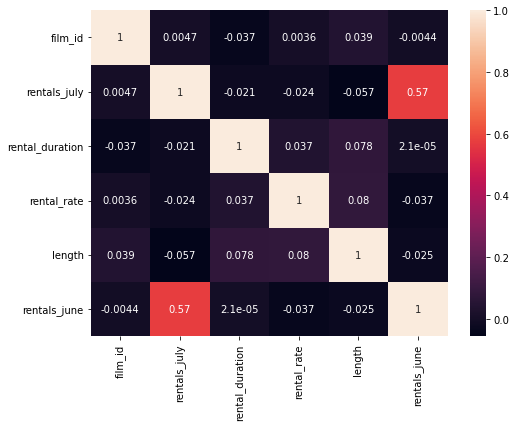

In [13]:
corr_matrix= pd_df.corr(method='pearson') 
fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [14]:
y = pd_df['rents_bigger_in_july?']

X = pd_df.drop(['rents_bigger_in_july?', 'film_id', 'title', 'rentals_july', 'rentals_june'], axis=1)

Decided to drop film_id, title and both rentals because they would overcomplicate the model too much by adding hundreds of extra columns

In [26]:
X.shape

(627, 5)

In [27]:
y.shape

(627,)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(438, 5)
(189, 5)
(438,)
(189,)


In [29]:
X_train_numeric = X_train.select_dtypes(include = np.number)

X_test_numeric = X_test.select_dtypes(include = np.number)

# X_train_num to norm

transformer = MinMaxScaler().fit(X_train_numeric)

X_train_normalized = transformer.transform(X_train_numeric)

X_train_norm = round(pd.DataFrame(X_train_normalized, columns=X_train_numeric.columns, index=X_train_numeric.index),2)

# X_test_num to norm

X_test_normalized = transformer.transform(X_test_numeric)

X_test_norm = round(pd.DataFrame(X_test_normalized, columns=X_test_numeric.columns, index=X_test_numeric.index),2)

X_train_norm

,rental_duration,rental_rate,length
398,0.75,0.5,0.60
158,0.75,0.0,0.11
3,0.75,0.5,0.60
473,1.00,0.5,0.94
202,0.25,0.0,0.68
...,...,...,...
307,0.75,0.5,0.83
314,0.25,1.0,0.15
374,0.50,1.0,0.10
666,0.00,1.0,0.73


In [17]:
# Repetir con X_test, sacar plots de las distribuciones para checkear skewness --- el standard scaler normaliza la serie 

In [30]:
X_train_categorical = X_train.select_dtypes(include = object)

X_test_categorical = X_test.select_dtypes(include = object)


X_train_cat = pd.get_dummies(X_train_categorical, 
                             columns=['rating', 'name'],
                             drop_first=True)

X_test_cat = pd.get_dummies(X_test_categorical, 
                             columns=['rating', 'name'],
                             drop_first=True)

X_train_cat.head()

,rating_NC-17,rating_PG,rating_PG-13,rating_R,name_Animation,name_Children,name_Classics,name_Comedy,name_Documentary,name_Drama,name_Family,name_Foreign,name_Games,name_Horror,name_Music,name_New,name_Sci-Fi,name_Sports,name_Travel
398,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
158,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
473,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
202,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [31]:
X_train_transformed = pd.concat([X_train_norm, X_train_cat], axis=1)

X_test_transformed = pd.concat([X_test_norm, X_test_cat], axis=1)


#X_train_transformed = X_train_transformed.dropna()



In [32]:
X_train_transformed.isna().sum()

rental_duration     0
rental_rate         0
length              0
rating_NC-17        0
rating_PG           0
rating_PG-13        0
rating_R            0
name_Animation      0
name_Children       0
name_Classics       0
name_Comedy         0
name_Documentary    0
name_Drama          0
name_Family         0
name_Foreign        0
name_Games          0
name_Horror         0
name_Music          0
name_New            0
name_Sci-Fi         0
name_Sports         0
name_Travel         0
dtype: int64

In [33]:
X_train.shape, y_train.shape

((438, 5), (438,))

In [35]:
X_test.shape, y_test.shape

((189, 5), (189,))

7) Create a logistic regression model to predict this new column from the cleaned data.

In [22]:
X_train_transformed.shape

(627, 22)

In [24]:
y_train.shape

(438,)

In [36]:
classification = LogisticRegression(random_state=2, solver='lbfgs',
                  multi_class='multinomial').fit(X_train_transformed, y_train)


In [42]:
y_pred_train = classification.predict(X_train_transformed)

classification.score(X_train_transformed, y_train)

0.769406392694064

In [40]:
y_pred_test = classification.predict(X_test_transformed)

classification.score(X_test_transformed, y_test)

0.7724867724867724

In [43]:
cohen_kappa_score(y_train, y_pred_train)

0.010556922388727408

In [41]:
cohen_kappa_score(y_test, y_pred_test)

0.03445408102649394